In [1]:
#data related imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

from huggingface_hub import login,HfApi, upload_file


# classification model imports
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# deep learning model imports
from keras.callbacks import EarlyStopping

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os



import time



In [ ]:
df = pd.read_csv('E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv', low_memory=False)

In [ ]:
print(df['Attack_type'].value_counts())

In [ ]:
print(df.columns)

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.head()

In [ ]:
print(df.isnull().sum())

In [ ]:
print(df.duplicated().sum())

# decision tree classifier

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

# Step 1: Drop object columns
X = df.drop(columns=['Attack_label'])  # Drop target and any duplicates
X = X.select_dtypes(include=['int64', 'float64', 'bool'])  # Keep numeric features only

# Step 2: Set target
y = df['Attack_label']

# Train-val-test split: 70/20/10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)


In [ ]:
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

In [ ]:
print("X shape:", X.shape)
print("X columns:", X.columns.tolist())

In [ ]:



model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,       # Disable the label encoder warning
    objective='binary:logistic',   # Important: binary classification objective
    eval_metric='logloss'          # Evaluation metric
)

# Start timer
start_time = time.time()

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True  # Optional: shows training log
)

# End timer
end_time = time.time()

model.save_model("xgb_model.json")

# upload_file(
#     path_or_fileobj="xgb_model.json",  # or "xgb_model.pkl"
#     path_in_repo="xgb_model.json",     # File name in the repo
#     repo_id="ScHemer34/DT_XGBoost",
#     repo_type="model"
# )


In [ ]:
y_pred = model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['normal', 'attack']))

# Print duration
training_duration = end_time - start_time
print(f"\n✅ Model trained in {training_duration:.2f} seconds")

# Dataset for Deep Learning Models

In [2]:
df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path
print(df_fnn.shape)
df_fnn.info()



C:\Users\afnan\AppData\Local\Temp\ipykernel_11820\2324740219.py:1: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path


(2219201, 63)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 63 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   frame.time                 object 
 1   ip.src_host                object 
 2   ip.dst_host                object 
 3   arp.dst.proto_ipv4         object 
 4   arp.opcode                 float64
 5   arp.hw.size                float64
 6   arp.src.proto_ipv4         object 
 7   icmp.checksum              float64
 8   icmp.seq_le                float64
 9   icmp.transmit_timestamp    float64
 10  icmp.unused                float64
 11  http.file_data             object 
 12  http.content_length        float64
 13  http.request.uri.query     object 
 14  http.request.method        object 
 15  http.referer               object 
 16  http.request.full_uri      object 
 17  http.request.version       object 
 18  http.response              float64
 19  http.tls_port              f

In [ ]:
df_lstm = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path
print(df_lstm.shape)
df_lstm.info()


# Feed Forward Neural Network

In [3]:
import torch.nn as nn


class LinearNN(nn.Module):
    def __init__(self, input_size):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.output = nn.Linear(8, 1)  # Output = 1 for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.output(x)  # No sigmoid here if using BCEWithLogitsLoss
        return x

In [3]:
# Drop rows with missing values
df_fnn.dropna(inplace=True)

#encoding important columns
# Initialize encoder
method_encoder = LabelEncoder()

# Fit and transform
df_fnn['http.request.method_encoded'] = method_encoder.fit_transform(df_fnn['http.request.method'].astype(str))
df_fnn['http.request.version_encoded'] = np.where(df_fnn['http.request.version'].astype(str).str.strip() == '0', 0, 1)
df_fnn['mqtt_topic'] = method_encoder.fit_transform(df_fnn['mqtt.topic'].astype(str))
df_fnn['mqtt_protoname'] = method_encoder.fit_transform(df_fnn['mqtt.protoname'].astype(str))
df_fnn['Attack_type'] = np.where(df_fnn['Attack_type'].astype(str).str.strip() == 'normal', 0, 1)


# Step 2: Set target
y_fnn = df_fnn['Attack_label']

# Now drop object and unnecessary columns
X_fnn = df_fnn.drop(columns=[
    'Attack_label', 'http.request.full_uri', 'http.referer', 'http.file_data', 
    'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
    'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
    'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
    'dns.qry.name.len','mqtt.conack.flags'
])

In [4]:

# First split: Train 70%, Temp 30%
X_train_fnn, X_temp_fnn, y_train_fnn, y_temp_fnn = train_test_split(
    X_fnn, y_fnn, test_size=0.3, stratify=y_fnn, random_state=42
)

# Second split: Validation 20% (2/3 of 30%), Test 10% (1/3 of 30%)
X_val_fnn, X_test_fnn, y_val_fnn, y_test_fnn = train_test_split(
    X_temp_fnn, y_temp_fnn, test_size=1/3, stratify=y_temp_fnn, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train_fnn = X_train_fnn.reset_index(drop=True)
X_val_fnn = X_val_fnn.reset_index(drop=True)
X_test_fnn = X_test_fnn.reset_index(drop=True)

y_train_fnn = y_train_fnn.reset_index(drop=True)
y_val_fnn = y_val_fnn.reset_index(drop=True)
y_test_fnn = y_test_fnn.reset_index(drop=True)


In [5]:
overlap = set(map(tuple, X_train_fnn.values)) & set(map(tuple, X_val_fnn.values))
print(f"Train/Val Overlap: {len(overlap)}")  # Should be 0

Train/Val Overlap: 69374


In [6]:
print("Train class distribution:\n", y_train_fnn.value_counts())
print("Validation class distribution:\n", y_val_fnn.value_counts())
print("Test class distribution:\n", y_test_fnn.value_counts())

Train class distribution:
 Attack_label
0    1130950
1     422490
Name: count, dtype: int64
Validation class distribution:
 Attack_label
0    323128
1    120712
Name: count, dtype: int64
Test class distribution:
 Attack_label
0    161565
1     60356
Name: count, dtype: int64


In [6]:
for col in X_fnn.columns:
    if X_fnn[col].apply(type).nunique() > 1:
        print(f"{col}: {X_fnn[col].apply(type).value_counts()}")

In [ ]:
X_fnn.info()


In [7]:
#normalize the data
# scaler = StandardScaler()
# X_train_fnn = scaler.fit_transform(X_train_fnn)
# X_val_fnn = scaler.transform(X_val_fnn)
# X_test_fnn = scaler.transform(X_test_fnn)

print(X_fnn.dtypes[X_fnn.dtypes == 'object'])

# convert dataframe to pytorch tensors
X_train_tensor_fnn = torch.tensor(X_train_fnn.to_numpy(), dtype=torch.float32)
y_train_tensor_fnn = torch.tensor(y_train_fnn.to_numpy(), dtype=torch.float32)

X_val_tensor_fnn = torch.tensor(X_val_fnn.to_numpy(), dtype=torch.float32)
y_val_tensor_fnn = torch.tensor(y_val_fnn.to_numpy(), dtype=torch.float32)

Series([], dtype: object)


In [8]:
# Start timer
start_time_fnn = time.time()

model_fnn = LinearNN(input_size=X_train_fnn.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_fnn.parameters(), lr=0.0001)

num_epochs = 30
for epoch in range(num_epochs):
    model_fnn.train()
    
    outputs = model_fnn(X_train_tensor_fnn).squeeze()
    loss = criterion(outputs, y_train_tensor_fnn.float())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Calculate validation loss
    model_fnn.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients during validation
        val_outputs = model_fnn(X_val_tensor_fnn).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor_fnn.float())

    # Print epoch information
    model_fnn.train()  # Set model back to training mode
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


# End timer
end_time_fnn = time.time()

torch.save(model_fnn.state_dict(), "linear_nn_model.pth")

Epoch [1/30], Loss: 14127033.0000, Val Loss: 14088618.0000
Epoch [2/30], Loss: 14086947.0000, Val Loss: 14048589.0000
Epoch [3/30], Loss: 14046937.0000, Val Loss: 14008634.0000
Epoch [4/30], Loss: 14007001.0000, Val Loss: 13968753.0000
Epoch [5/30], Loss: 13967140.0000, Val Loss: 13928954.0000
Epoch [6/30], Loss: 13927359.0000, Val Loss: 13889229.0000
Epoch [7/30], Loss: 13887656.0000, Val Loss: 13849585.0000
Epoch [8/30], Loss: 13848032.0000, Val Loss: 13810023.0000
Epoch [9/30], Loss: 13808487.0000, Val Loss: 13770543.0000
Epoch [10/30], Loss: 13769025.0000, Val Loss: 13731145.0000
Epoch [11/30], Loss: 13729648.0000, Val Loss: 13691829.0000
Epoch [12/30], Loss: 13690354.0000, Val Loss: 13652601.0000
Epoch [13/30], Loss: 13651143.0000, Val Loss: 13613455.0000
Epoch [14/30], Loss: 13612017.0000, Val Loss: 13574398.0000
Epoch [15/30], Loss: 13572977.0000, Val Loss: 13535428.0000
Epoch [16/30], Loss: 13534027.0000, Val Loss: 13496546.0000
Epoch [17/30], Loss: 13495163.0000, Val Loss: 134

In [9]:
model_fnn.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_fnn.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_fnn.values, dtype=torch.float32)

    outputs = model_fnn(X_test_tensor).squeeze()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

    correct = (preds == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.shape[0]

print(f"\n🧪 Test Accuracy: {accuracy:.4f}")

# Print duration
training_duration_fnn = end_time_fnn - start_time_fnn
print(f"⏱️ Model trained in {training_duration_fnn:.2f} seconds")


🧪 Test Accuracy: 0.7280
⏱️ Model trained in 12.76 seconds


# Long Short Term Memory


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [8]:
timesteps = 1

num_features = X_train_fnn.shape[1]

# --- Step 1: Convert DataFrames to NumPy Arrays ---
X_train_np = X_train_fnn.to_numpy()
y_train_np = y_train_fnn.to_numpy().reshape(-1, 1)

X_val_np = X_val_fnn.to_numpy()
y_val_np = y_val_fnn.to_numpy().reshape(-1, 1)

# --- Step 2: Scale Features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled = scaler.transform(X_val_np)  # use transform only on val

X_train_lstm = X_train_scaled.reshape(-1, timesteps, num_features)
X_val_lstm = X_val_scaled.reshape(-1, timesteps, num_features)


In [9]:
intersection = set(map(tuple, X_train_np)) & set(map(tuple, X_val_np))
print(f"Overlapping samples: {len(intersection)}")

Overlapping samples: 69374


In [9]:
# ---------- 2. Define LSTM model ----------
model = Sequential()
model.add(LSTM(32, return_sequences=False, input_shape=(timesteps, num_features)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Step 5: Train
start_time_lstm = time.time()
history = model.fit(
    X_train_lstm, 
    y_train_np,                # use y_full if labels are binary
    validation_data=(X_val_lstm, y_val_np), #validation checking dataset
    epochs=2,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
end_time_lstm = time.time()
training_duration_lstm = end_time_lstm - start_time_lstm
print(f"training duration is: {training_duration_lstm}")

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
24273/24273 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.9887 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 1.8871e-11
Epoch 2/2
24273/24273 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 1.0000 - loss: 2.8114e-08 - val_accuracy: 1.0000 - val_loss: 1.0822e-13
training duration is: 98.37376022338867


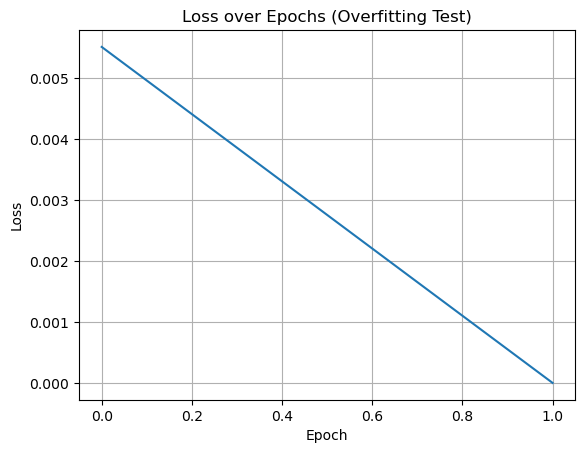

In [10]:
# ---------- 4. Check loss over time ----------
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [11]:
print("x_test_fnn shape:", X_test_fnn.shape)
print("timesteps:", timesteps)
print("num_features:", num_features)

x_test_fnn shape: (221921, 46)
timesteps: 1
num_features: 46


In [12]:
X_test_array = X_test_fnn.to_numpy()  # Convert to numpy array
y_test_np = y_test_fnn.to_numpy().reshape(-1, 1)

# Check shape of X_test_array
print("X_test_array shape:", X_test_array.shape)

# Reshape to (samples, timesteps, num_features)
X_test_lstm = X_test_array.reshape((X_test_array.shape[0], timesteps, num_features))
print("X_test_lstm shape:", X_test_lstm.shape)

X_test_array shape: (221921, 46)
X_test_lstm shape: (221921, 1, 46)


In [13]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_np, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict
y_pred_prob = model.predict(X_test_lstm)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_np, y_pred))

6936/6936 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8258 - loss: 1.9018
Test Loss: 1.8798
Test Accuracy: 0.8270
6936/6936 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.96      0.89    161565
           1       0.81      0.47      0.60     60356

    accuracy                           0.83    221921
   macro avg       0.82      0.72      0.74    221921
weighted avg       0.83      0.83      0.81    221921



In [20]:
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_test_np shape:", y_test_np.shape)
print("X_test_lstm dtype:", X_test_lstm.dtype)
print("y_test_np dtype:", y_test_np.dtype)

X_test_lstm shape: (221921, 1, 46)
y_test_np shape: (221921,)
X_test_lstm dtype: float64
y_test_np dtype: int64


In [4]:
import torch.nn as lstm

class LSTMModel(lstm.Module):
    def __init__(self, input_size, hidden_size=32):
        super(LSTMModel, self).__init__()
        self.lstm1 = lstm.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
#         self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = lstm.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
#         out, _ = self.lstm2(out)  # note: this should take 'out' from lstm1
        out = out[:, -1, :]
        out = self.fc(out)
        return out



In [6]:

# Step 1: Scale the features
scaler = MinMaxScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train_fnn)
X_val_scaled_lstm = scaler.transform(X_val_fnn)
X_test_scaled_lstm = scaler.transform(X_test_fnn)


# Step 2: Convert features to tensors (and unsqueeze for LSTM shape: [batch, seq_len, input_size])
X_train_tensor_lstm = torch.tensor(X_train_scaled_lstm, dtype=torch.float32).unsqueeze(1)
X_val_tensor_lstm = torch.tensor(X_val_scaled_lstm, dtype=torch.float32).unsqueeze(1)
X_test_tensor_lstm = torch.tensor(X_test_scaled_lstm, dtype=torch.float32).unsqueeze(1)

# Step 2: Convert features to tensors (and unsqueeze for LSTM shape: [batch, seq_len, input_size])
# X_train_tensor_lstm = torch.tensor(X_train_fnn.values, dtype=torch.float32).unsqueeze(1)
# X_val_tensor_lstm = torch.tensor(X_val_fnn.values, dtype=torch.float32).unsqueeze(1)
# X_test_tensor_lstm = torch.tensor(X_test_fnn.values, dtype=torch.float32).unsqueeze(1)

# Step 3: Convert targets to tensors (and unsqueeze for [batch_size, 1] if needed)
y_train_tensor_lstm = torch.tensor(y_train_fnn.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_val_tensor_lstm = torch.tensor(y_val_fnn.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_tensor_lstm = torch.tensor(y_test_fnn.to_numpy(), dtype=torch.float32).unsqueeze(1)

# Step 4: Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# 3. Wrap tensors into a Dataset
train_dataset = TensorDataset(X_train_tensor_lstm, y_train_tensor_lstm)
val_dataset = TensorDataset(X_val_tensor_lstm, y_val_tensor_lstm)
test_dataset = TensorDataset(X_test_tensor_lstm, y_test_tensor_lstm)

# 4. Use DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)  # You can tune the batch size

Using device: cuda


In [7]:
print(y_train_tensor_lstm.mean().item())

0.27197059988975525


In [17]:
# Use a small subset
input_size = 46
model_lstm = LSTMModel(input_size=input_size).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
X_small = X_small[:, :, -5:]  # Last 5 columns where values are non-zero
X_small = X_train_tensor_lstm[:32].to(device)
y_small = y_train_tensor_lstm[:32].to(device)


model_lstm = LSTMModel(input_size=input_size).to(device)

for i in range(40):
    model_lstm.train()
    optimizer.zero_grad()
    out = model_lstm(X_small)
    loss = criterion(out, y_small)
    print("out range:", out.min().item(), out.max().item())
    loss.backward()
    optimizer.step()
    print(f"Epoch {i}, Loss: {loss.item():.4f}")

out range: 0.04480889439582825 0.13782501220703125
Epoch 0, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 1, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 2, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 3, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 4, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 5, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 6, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 7, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 8, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 9, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 10, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 11, Loss: 0.2094
out range: 0.04480889439582825 0.13782501220703125
Epoch 12, Loss: 0.2094
out range: 0.04480889439582825 0.137825012207031

In [11]:
print("out.shape", out.shape)
print("y_small shape:", y_small.shape)

out.shape torch.Size([32, 1])
y_small shape: torch.Size([32, 1])


In [19]:
print(X_small.squeeze().cpu().numpy())  # shape (32, 46)

[[0.  0.  0.  ... 1.  0.5 0.5]
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 1.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 1.  0.5 0.5]]


In [12]:
print(y_small.dtype)

torch.float32


In [13]:
print("X_small shape:", X_small.shape)

X_small shape: torch.Size([32, 1, 46])


In [20]:
from sklearn.decomposition import PCA

X_np = X_train_tensor_lstm.squeeze(1).cpu().numpy()
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X_np)

print(pca.explained_variance_ratio_)  # see how much signal is in first few features


[0.27292519 0.16396384 0.10222466 0.08529597 0.0666497 ]


In [23]:
print("Train label distribution:", torch.unique(y_train_tensor_lstm, return_counts=True))
print("Val label distribution:", torch.unique(y_val_tensor_lstm, return_counts=True))

Train label distribution: (tensor([0., 1.]), tensor([1130950,  422490]))
Val label distribution: (tensor([0., 1.]), tensor([323128, 120712]))


In [16]:
print("Train:", y_train_tensor_lstm.mean().item(), "Std:", y_train_tensor_lstm.std().item())
print("Val:", y_val_tensor_lstm.mean().item(), "Std:", y_val_tensor_lstm.std().item())

Train: 0.27197059988975525 Std: 0.44497495889663696
Val: 0.2719718813896179 Std: 0.44497597217559814


In [27]:
print("Input example:", X_train_tensor_lstm[4])
print("Target example:", y_train_tensor_lstm[4])

Input example: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.4391, 0.0000, 0.0000, 1.0000, 0.0000, 0.0287, 0.0800,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 1.0000, 0.0000,
         0.0000]])
Target example: tensor([0.])


In [ ]:
torch.backends.mkldnn.enabled = False

# Initialize model, loss, and optimizer
input_size = X_train_tensor_lstm.shape[2]
model_lstm = LSTMModel(input_size=input_size).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

print(f"Using device: {device}")

# Training loop
num_epochs = 15
start_time_lstm = time.time()


for epoch in range(num_epochs):
    model_lstm.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
#         print(outputs[:5].detach().cpu().numpy())
#         print(y_batch[:5].cpu().numpy())
        loss = criterion(outputs, y_batch)
        loss.backward()
        for name, param in model_lstm.named_parameters():
            if param.grad is not None:
                print(f"{name}: {param.grad.abs().mean().item():.6f}")
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model_lstm(X_val_batch)
            loss = criterion(val_outputs, y_val_batch)
            val_loss += loss.item() * X_val_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

end_time_lstm = time.time()
training_duration_lstm = end_time_lstm - start_time_lstm

# Save the model
torch.save(model_lstm.state_dict(), "lstm_model.pth")
print(f"\nTraining time: {training_duration_lstm:.2f} seconds")

In [ ]:
model_lstm.eval()
with torch.no_grad():
    example_output = model_lstm(X_val_tensor_lstm[:5])
    print("Sample outputs:", example_output.squeeze())

In [ ]:
print("Train and Val X equal?", torch.equal(X_train_tensor_lstm, X_val_tensor_lstm))
print("Train and Val y equal?", torch.equal(y_train_tensor_lstm, y_val_tensor_lstm))
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

In [ ]:
# Evaluate on test set
model_lstm.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_lstm(X_batch)
        predicted = torch.sigmoid(outputs)
        predicted_classes = (predicted >= 0.5).float()
        
        all_preds.append(predicted_classes)
        all_labels.append(y_batch)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Accuracy
accuracy = (all_preds == all_labels).float().mean()
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Training duration: {training_duration_lstm:.2f} seconds")
